In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1


In [ ]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0
corpus = []
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        list_item.append(row[5])
        if row[0] == '4':
          list_item.append(1)
        else:
          list_item.append(0)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2021-04-02 06:18:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 172.217.13.80, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   262MB/s    in 0.9s    

2021-04-02 06:18:17 (262 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])# YOUR CODE HERE
    labels.append(corpus[x][1])# YOUR CODE HERE


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)# YOUR CODE HERE

word_index = tokenizer.word_index
vocab_size= len(word_index)# YOUR CODE HERE)

sequences = tokenizer.texts_to_sequences(sentences)# YOUR CODE HERE
padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)# YOUR CODE HERE)

split = int(test_portion * training_size)

test_sequences = padded[0:split]# YOUR CODE HERE]
training_sequences = padded[split:training_size]# YOUR CODE HERE]
test_labels = labels[0:split]# YOUR CODE HERE]
training_labels = labels[split:training_size]# YOUR CODE HERE]

In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138155
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-04-02 06:20:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.9.208, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-04-02 06:20:28 ERROR 404: Not Found.



In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138156


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    '''
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    '''
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])# YOUR CODE HERE
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           13815600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 13,908,401
Trainable params: 92,801
Non-trainable params: 13,815,600
_________________________________________________________________


In [ ]:
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 20s - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 2/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 3/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/50
4500/4500 - 19s - loss: 0.6931 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 5/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 6/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 7/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 8/50
4500/4500 - 19s - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.4985
Epoch 9/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 10/50
4500/4500 - 19s - loss: 0.6932 - accuracy: 0.5013 - val_loss:

<Figure size 432x288 with 0 Axes>

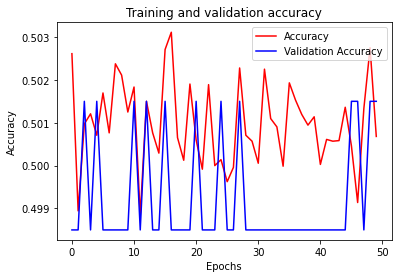

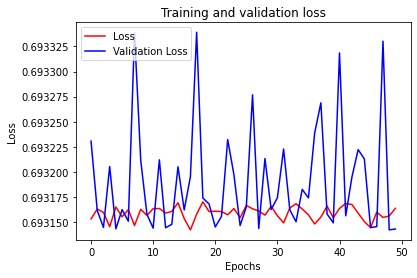

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!